In [17]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import shap

In [4]:
# 2. Load training data
df = pd.read_excel("../data/train_data.xlsx")
# Display basic information
display(df.head())
print(df.info())

,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History,Need_Supplement
0,t1,68,Female,30.0,203.8,111.8,44.0,157.3,Low,Healthy,No,0
1,t2,58,Female,30.3,188.1,182.4,50.6,234.8,High,Moderate,No,1
2,t3,44,Male,20.9,194.3,74.7,60.1,97.2,High,Healthy,Yes,0
3,t4,72,Female,35.0,198.4,120.2,43.5,202.0,High,Healthy,No,1
4,t5,37,Male,22.9,277.3,186.1,36.7,156.3,Low,Moderate,Yes,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    object 
 1   Age                100 non-null    int64  
 2   Gender             100 non-null    object 
 3   BMI                100 non-null    float64
 4   Total_Cholesterol  100 non-null    float64
 5   LDL_Cholesterol    100 non-null    float64
 6   HDL_Cholesterol    100 non-null    float64
 7   Triglycerides      100 non-null    float64
 8   Physical_Activity  100 non-null    object 
 9   Dietary_Habits     100 non-null    object 
 10  Family_History     100 non-null    object 
 11  Need_Supplement    100 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 9.5+ KB
None


In [50]:
# 3. Preprocess the data
# Assuming target column is named 'Needs_Supplement'
target_col = "Need_Supplement"
X = df.drop(columns=[target_col])
y = df[target_col]

# After all encoding/imputation
X = pd.get_dummies(X).fillna(0)

# Scale, then wrap into DataFrame
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [51]:
# 4. Hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


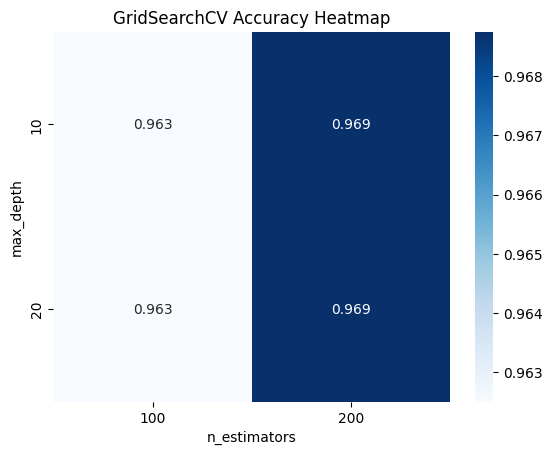

In [52]:
# Visualize cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
pivot_table = cv_results.pivot_table(
    index="param_max_depth", columns="param_n_estimators", values="mean_test_score"
)

sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="Blues")
plt.title("GridSearchCV Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

In [53]:
# 5. Train final model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [22]:
# Predictions and evaluation
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.83      0.91        12

    accuracy                           0.90        20
   macro avg       0.90      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20



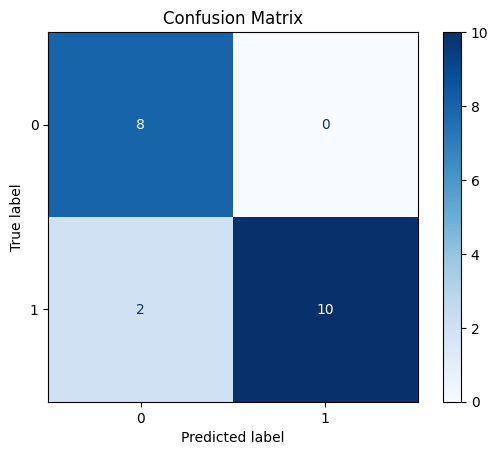

In [23]:
# 6. Visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

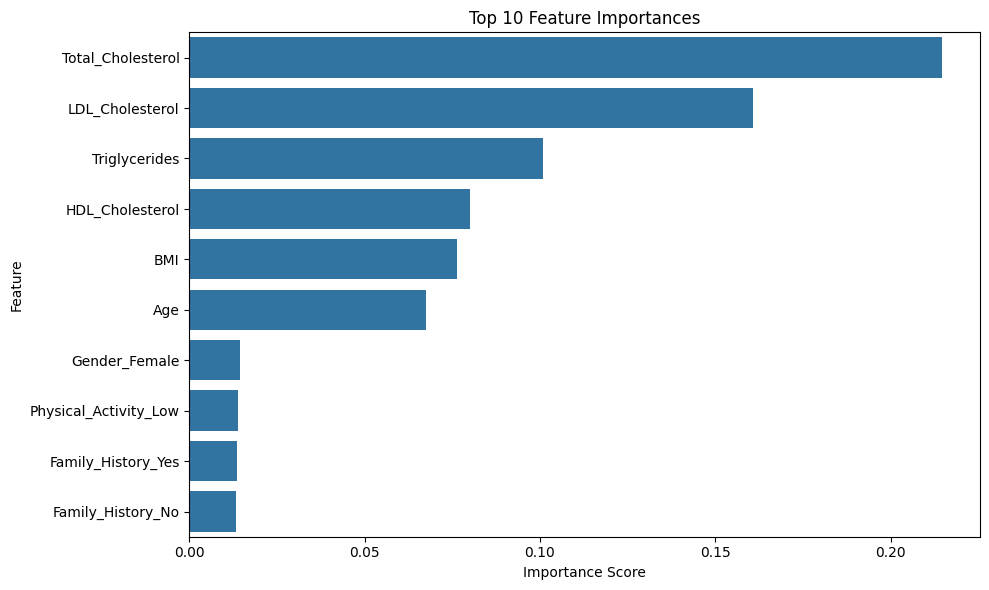

In [24]:
# 7. Feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=feature_names[indices][:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [11]:
# 8. Load prediction data
predict_df = pd.read_excel("../data/predict_data.xlsx")
predict_df_processed = pd.get_dummies(predict_df)

In [12]:
predict_df_processed = predict_df_processed.reindex(columns=X.columns, fill_value=0)

In [25]:
# 9. Predict for new patients
predict_scaled = scaler.transform(predict_df_processed)
predictions = best_model.predict(predict_scaled)

# 10. Submit predictions
results = predict_df.copy()
results["Needs_Supplement_Prediction"] = predictions

# Display results
display(results)

,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History,Needs_Supplement_Prediction
0,v1,38,Male,23.1,169.3,105.3,47.4,125.8,High,Healthy,Yes,0
1,v2,53,Male,33.1,271.7,189.5,31.6,235.3,Low,Moderate,Yes,1
2,v3,30,Female,30.8,273.1,153.6,57.4,194.3,Moderate,Healthy,No,1
3,v4,73,Female,34.2,243.9,116.1,56.7,59.6,Low,Unhealthy,Yes,1
4,v5,37,Female,24.0,273.1,158.5,47.8,206.3,Low,Healthy,No,1
5,v6,53,Male,27.6,247.7,179.8,74.7,215.6,Moderate,Unhealthy,No,1
6,v7,40,Male,27.9,181.0,185.0,36.4,200.1,Moderate,Unhealthy,No,1
7,v8,46,Female,34.7,191.1,76.9,46.5,209.9,Moderate,Healthy,Yes,1
8,v9,37,Female,19.7,182.2,117.3,46.1,215.0,High,Unhealthy,Yes,1
9,v10,64,Female,23.5,206.6,82.8,34.6,87.3,Low,Moderate,Yes,0


In [14]:
# Optionally export to Excel
results.to_excel("../data/cholesterol_predictions.xlsx", index=False)

In [58]:
# Initialize TreeExplainer

print("Are you passing a DataFrame?", isinstance(X_test, pd.DataFrame))
print("Shape:", X_test.shape)
print("First few column names:", list(X_test.columns[:5]))
print("Sample row:\n", X_test.iloc[0])

explainer = shap.TreeExplainer(best_model)

# Confirm the type and shape
print("X_test shape:", X_test.shape)  # should be (20, 116)
print("X_test type:", type(X_test))  # should be DataFrame

shap_values = explainer.shap_values(X_test)

# Check shapes
print("SHAP[0] shape:", np.array(shap_values[0]).shape)  # should be (20, 116)
print("SHAP[1] shape:", np.array(shap_values[1]).shape)

Are you passing a DataFrame? True
Shape: (20, 116)
First few column names: ['Age', 'BMI', 'Total_Cholesterol', 'LDL_Cholesterol', 'HDL_Cholesterol']
Sample row:
 Age                        -0.004870
BMI                         1.581602
Total_Cholesterol           0.717601
LDL_Cholesterol            -1.296172
HDL_Cholesterol             1.124411
                              ...   
Dietary_Habits_Healthy     -0.685994
Dietary_Habits_Moderate    -0.670280
Dietary_Habits_Unhealthy    1.304877
Family_History_No          -1.040833
Family_History_Yes          1.040833
Name: 98, Length: 116, dtype: float64
X_test shape: (20, 116)
X_test type: <class 'pandas.core.frame.DataFrame'>
SHAP[0] shape: (116, 2)
SHAP[1] shape: (116, 2)


In [61]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def explain_with_shap(model, X_test, class_index=1, max_display=10):
    """
    Safely explains a tree-based classification model using SHAP.
    Handles both list-based and array-based SHAP outputs.

    Parameters:
    - model: Trained tree-based classifier (e.g., RandomForestClassifier)
    - X_test: pandas DataFrame with features
    - class_index: Index of class to explain (default=1 for binary classification)
    - max_display: Features to display in summary plot
    """

    import shap
    import numpy as np

    print("🔍 Validating input...")
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame with named columns.")

    # Initialize SHAP
    print("✅ Initializing SHAP TreeExplainer...")
    explainer = shap.TreeExplainer(model)

    print("📊 Computing SHAP values...")
    shap_values = explainer.shap_values(X_test)

    # Determine SHAP format (list vs array)
    if isinstance(shap_values, list):
        # Older SHAP version: list of arrays per class
        print("📦 Detected SHAP output as list of class-specific arrays.")
        shap_class_values = shap_values[class_index]

    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # New SHAP format: 3D array (samples, features, classes)
        print(
            "📦 Detected SHAP output as 3D array. Extracting class-specific SHAP values..."
        )
        shap_class_values = shap_values[:, :, class_index]
    else:
        raise ValueError("Unsupported SHAP output format.")

    # Shape validation
    if shap_class_values.shape != X_test.shape:
        raise AssertionError(
            f"Shape mismatch: SHAP values shape {shap_class_values.shape} ≠ X_test shape {X_test.shape}"
        )

    # Summary plot
    print("📈 Generating SHAP summary plot...")
    shap.summary_plot(shap_class_values, X_test, max_display=max_display)

    # Force plot
    print("📌 Showing SHAP force plot for first test sample...")
    shap.initjs()
    try:
        shap.force_plot(
            explainer.expected_value[class_index],
            shap_class_values[0],
            X_test.iloc[0],
            matplotlib=True,
        )
    except Exception as e:
        print(f"⚠️ Force plot failed: {e}")

🔍 Validating input...
✅ Initializing SHAP TreeExplainer...
📊 Computing SHAP values...
📦 Detected SHAP output as 3D array. Extracting class-specific SHAP values...
📈 Generating SHAP summary plot...


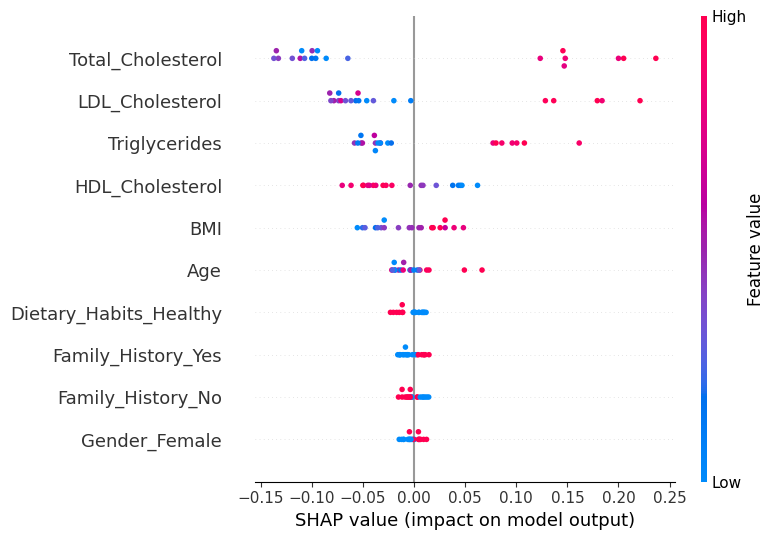

📌 Showing SHAP force plot for first test sample...


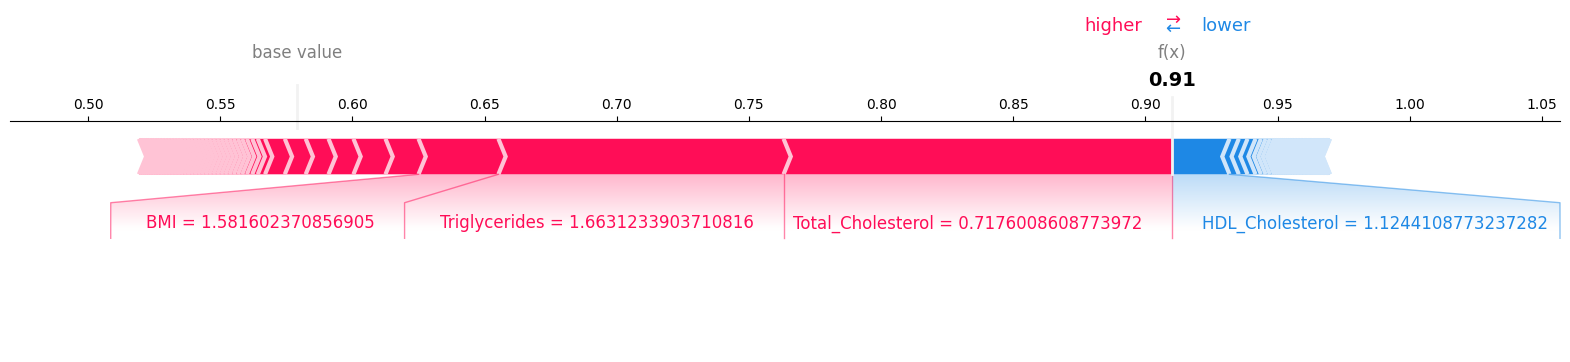

In [62]:
explain_with_shap(model=best_model, X_test=X_test)

In [63]:
def export_shap_to_excel(
    model, X_test, output_file="shap_values_export.xlsx", class_index=1
):
    """
    Exports SHAP values for a classification model to an Excel file.

    Parameters:
    - model: Trained classifier (e.g., RandomForestClassifier)
    - X_test: pandas DataFrame of test features
    - output_file: filename for Excel export
    - class_index: class to explain (default = 1 for positive class)
    """

    import shap
    import pandas as pd
    import numpy as np

    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame with named columns.")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Handle both legacy and new SHAP formats
    if isinstance(shap_values, list):
        shap_class_values = shap_values[class_index]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_class_values = shap_values[:, :, class_index]
    else:
        raise ValueError("Unsupported SHAP output format.")

    if shap_class_values.shape != X_test.shape:
        raise AssertionError(
            f"Shape mismatch: SHAP values shape {shap_class_values.shape} ≠ X_test shape {X_test.shape}"
        )

    # Convert to DataFrame
    shap_df = pd.DataFrame(shap_class_values, columns=X_test.columns)
    shap_df.index = X_test.index  # Optional: match index

    # Include base value and predicted class probabilities
    base_value = explainer.expected_value[class_index]
    shap_df["SHAP_base_value"] = base_value
    shap_df["Model_Prediction"] = model.predict(X_test)
    shap_df["Model_Probability"] = model.predict_proba(X_test)[:, class_index]

    # Export
    shap_df.to_excel(output_file, index=True)
    print(f"✅ SHAP values successfully exported to: {output_file}")

In [64]:
export_shap_to_excel(model=best_model, X_test=X_test)

✅ SHAP values successfully exported to: shap_values_export.xlsx


In [65]:
# Load prediction data
predict_df = pd.read_excel("../data/predict_data.xlsx")

# One-hot encode and align columns with training data
predict_df_encoded = pd.get_dummies(predict_df)
predict_df_encoded = predict_df_encoded.reindex(columns=X.columns, fill_value=0)

# Scale features
predict_scaled_array = scaler.transform(predict_df_encoded)
predict_scaled_df = pd.DataFrame(predict_scaled_array, columns=X.columns)

In [66]:
export_shap_to_excel(
    model=best_model,
    X_test=predict_scaled_df,
    output_file="shap_values_predictions_20_patients.xlsx",
    class_index=1,
)

✅ SHAP values successfully exported to: shap_values_predictions_20_patients.xlsx
